# Get data

In [7]:
import hopsworks

project = hopsworks.login()
fs = project.get_feature_store()
acm_papers_fg = fs.get_feature_group("acm_papers", 1)
df = acm_papers_fg.read()
df

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/196758
Connected. Call `.close()` to terminate connection gracefully.


Finished: Reading data from Hopsworks, using Hive (22.09s) 


,citation,abstract,publication_date
0,"@article{10.1504/ijcvr.2024.135131,\nauthor = ...",Plant diseases are a threat to the food supply...,2024-01-01
1,"@inproceedings{10.1007/978-3-031-23585-6_7,\na...",Abstract\nWith the continuous development of i...,2023-01-01
2,"@inproceedings{10.1007/978-3-031-23198-8_3,\na...",Abstract\nInternational Classification of Dise...,2023-01-01
3,"@inproceedings{10.1007/978-3-031-23028-8_26,\n...",Abstract\nThe point cloud is a 3D geometric da...,2023-01-01
4,"@inproceedings{10.1007/978-3-031-23028-8_25,\n...",Abstract\nTables are widely used in documents ...,2023-01-01
...,...,...,...
1017,"@inproceedings{10.1145/3620679.3620720,\nautho...",A fit person who is health conscious always co...,2023-12-19
1018,"@inproceedings{10.1145/3627341.3630366,\nautho...",This paper introduces a binary classification ...,2023-12-15
1019,"@inproceedings{10.1145/3617233.3617267,\nautho...",Glaciers play a critical role in the Earth’s c...,2023-12-30
1020,"@article{10.1145/3638353,\nauthor = {Li, Ximin...",Text Classification (TC) is a fundamental task...,2023-12-22


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   citation          1022 non-null   object
 1   abstract          1022 non-null   object
 2   publication_date  1022 non-null   object
dtypes: object(3)
memory usage: 24.1+ KB


In [27]:
# Remove duplicates
df_unique = df.drop_duplicates(subset=["abstract"], keep="first")

# Remove "Abstract\n" from the beginning of the abstract, it's a scraping error
scraping_error = "Abstract\n"
df_unique["abstract"] = df_unique["abstract"].str.replace(f'^{scraping_error}', "", regex=True)

df_unique

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,citation,abstract,publication_date
0,"@article{10.1504/ijcvr.2024.135131,\nauthor = ...",Plant diseases are a threat to the food supply...,2024-01-01
1,"@inproceedings{10.1007/978-3-031-23585-6_7,\na...",With the continuous development of information...,2023-01-01
2,"@inproceedings{10.1007/978-3-031-23198-8_3,\na...",International Classification of Disease (ICD) ...,2023-01-01
3,"@inproceedings{10.1007/978-3-031-23028-8_26,\n...",The point cloud is a 3D geometric data of irre...,2023-01-01
4,"@inproceedings{10.1007/978-3-031-23028-8_25,\n...",Tables are widely used in documents because of...,2023-01-01
...,...,...,...
999,"@inproceedings{10.1145/3615900.3628769,\nautho...",Reducing traffic accidents is a crucial global...,2023-11-29
1002,"@inproceedings{10.1007/978-3-031-48312-7_43,\n...",This paper presents an automatic dialect ident...,2023-11-29
1006,"@inproceedings{10.1007/978-3-031-48309-7_37,\n...",The article provides a description of the most...,2023-11-29
1010,"@inproceedings{10.1007/978-3-031-48312-7_33,\n...",Classification of normal vs. pathological infa...,2023-11-29


## Clean data

In [5]:
import subprocess

command = "python -m spacy download en_core_web_trf"
subprocess.run(command.split())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 2.3 MB/s eta 0:00:0000:0100:05
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


CompletedProcess(args=['python', '-m', 'spacy', 'download', 'en_core_web_trf'], returncode=0)

In [11]:
from spacy.lang.en import STOP_WORDS
import string

punctuations = string.punctuation
stop_words = list(STOP_WORDS)
stop_words[:10]

['except',
 'back',
 'around',
 'became',
 '’m',
 'seeming',
 'less',
 'nine',
 'together',
 'indeed']

In [13]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI'
]

for word in custom_stop_words:
    if word not in stop_words:
        stop_words.append(word)

In [28]:
import en_core_web_trf

parser = en_core_web_trf.load(disable=["tagger", "ner"])


def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [
        word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_
        for word in mytokens
    ]
    mytokens = [
        word for word in mytokens if word not in stop_words and word not in punctuations
    ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens


# Show progress bar
from tqdm import tqdm

tqdm.pandas()

df_unique["abstract_clean"] = df_unique["abstract"].progress_apply(spacy_tokenizer)
df_unique["abstract_clean"]

100%|██████████| 958/958 [01:53<00:00,  8.41it/s]
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0       plant diseases threat food supply reduce yield...
1       continuous development information technology ...
2       international classification disease icd codin...
3       point cloud 3d geometric data irregular format...
4       tables widely documents compact structured rep...
                              ...                        
999     reducing traffic accidents crucial global publ...
1002    paper presents automatic dialect identificatio...
1006    article provides description frequent bigrams ...
1010    classification normal vs. pathological infant ...
1012    automatic detection mental disorders mainly pe...
Name: abstract_clean, Length: 958, dtype: object

# Vectorization

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer


def vectorize(text, max_features_count):
    vectorizer = TfidfVectorizer(max_features=max_features_count)
    X = vectorizer.fit_transform(text)
    return X


text = df_unique["abstract_clean"].values
max_features_count = 2**12 # 4096 (just a big initial number, will be reduced later)
X = vectorize(text, max_features_count)

# print the shape of X
X.shape

(958, 4096)

# Principle Component Analysis (PCA)

In [37]:
from sklearn.decomposition import PCA

# Reduce the dimensionality of the TF-IDF matrix while retaining 95% of the variance
pca = PCA(n_components=0.95, random_state=42)
X_reduced = pca.fit_transform(X.toarray())
X_reduced.shape

(958, 793)

# K-Means Clustering

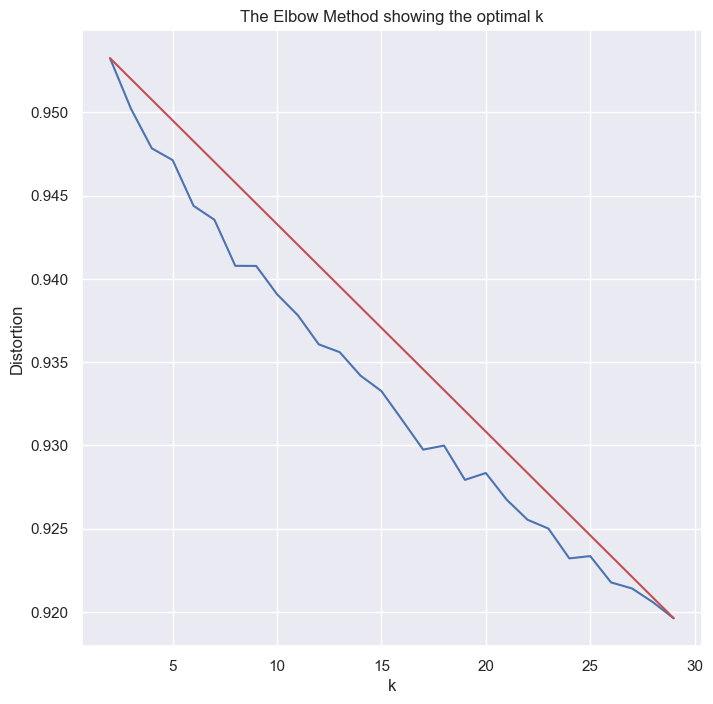

In [150]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
import numpy as np
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 30)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(
        sum(np.min(cdist(X_reduced, k_means.cluster_centers_, "euclidean"), axis=1))
        / X.shape[0]
    )


from matplotlib import pyplot as plt

X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, "b-")
plt.plot(X_line, Y_line, "r")
plt.xlabel("k")
plt.ylabel("Distortion")
plt.title("The Elbow Method showing the optimal k")
plt.show()

In [228]:
k = 16
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df_unique["y"] = y_pred

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Dimensionality Reduction with t-SNE

In [229]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=50)
X_embedded = tsne.fit_transform(X_reduced)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 958 samples in 0.002s...
[t-SNE] Computed neighbors for 958 samples in 0.032s...
[t-SNE] Computed conditional probabilities for sample 958 / 958
[t-SNE] Mean sigma: 0.277691
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.525490
[t-SNE] KL divergence after 1000 iterations: 1.690236


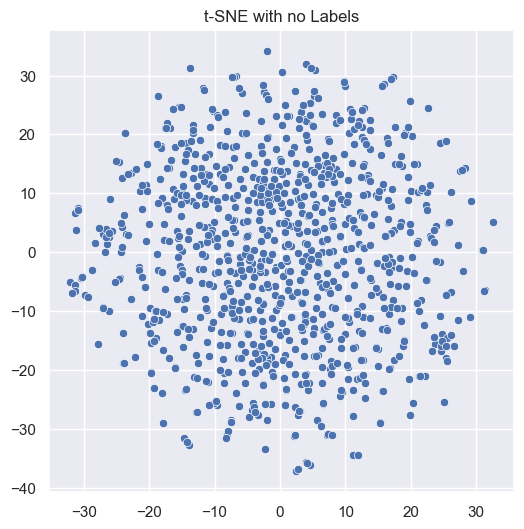

In [230]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(6,6)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
# plt.savefig("t-sne_covid19.png")
plt.show()

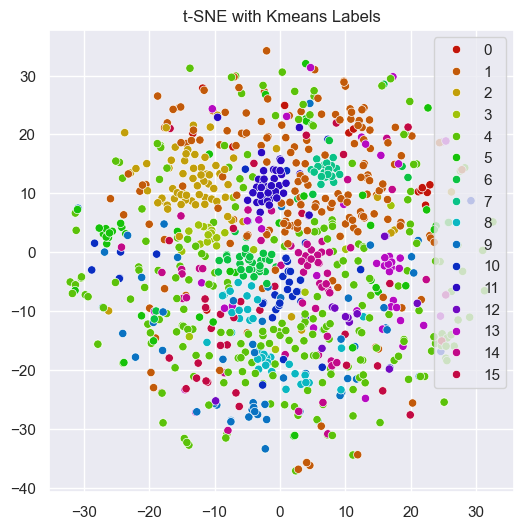

In [234]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(6,6)})

# colors
palette = sns.hls_palette(k, l=.4, s=.9)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
# plt.savefig("improved_cluster_tsne.png")
plt.show()